## Fruit trait prediction from image inputs

Input is an image and output is a multi scalar regression vector for the predicted fruit traits
these traits are measurements of the fruit.

The data is standardized

In [1]:
from fastai.vision.all import *

from fastcore.basics import Int
from fastcore.transform import DisplayedTransform
from fastcore.xtras import Path

from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import RandomSplitter, get_image_files, ColReader

from fastai.losses import MSELossFlat

from fastai.torch_core import ShowTitle, show_title, TitledFloat

from fastai.vision.augment import Resize, aug_transforms, Flip, Rotate, Zoom, Warp
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet50

from datetime import datetime, timedelta


import pandas as pd
from scipy.io import loadmat
import numpy as np

from scipy.io import loadmat
from datetime import datetime, timedelta

from fastai.metrics import mae, rmse, R2Score
from sklearn.model_selection import train_test_split

In [2]:
n_out_val      = 12
img_resize_val = 512

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = '/content/drive/MyDrive/School/ITS 530/Colab Notebooks/Mini Project 2 - Watermelonanalyzer/PhenotypeDataUGA.csv'

In [5]:
AllData = pd.read_csv(PATH)

In [6]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,147,6742,84.32,16.80,31.41,87.67,17.61,32.41,101.6,112.0,90.94,0.19,1.09,0.2
1,132,6744,75.96,18.63,25.27,82.09,19.57,26.66,118.3,122.7,73.39,0.18,0.93,0.2
2,20,6745,69.47,18.00,23.02,73.99,18.98,24.28,124.0,136.9,65.64,0.18,0.92,0.2
3,83,6746,74.58,14.73,27.44,80.63,15.52,28.92,108.6,101.7,63.50,0.18,0.81,0.2
4,119,6748,79.19,15.29,30.22,84.72,16.08,31.85,100.5,88.6,73.25,0.18,0.90,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,79.37,16.03,22.55,85.12,16.89,31.21,96.8,105.8,76.44,0.18,0.93,0.2
291,677,7722,54.35,15.63,16.64,58.76,16.44,17.33,144.5,139.6,48.75,0.21,0.87,0.2
292,1410,7723,49.77,14.02,15.43,57.10,14.79,16.22,138.5,143.7,37.69,0.20,0.69,0.2
293,1434,7727,67.71,18.25,22.06,73.26,19.23,23.25,145.2,126.5,69.12,0.20,0.98,0.2


## Standardize the traits in the pandas dataframe ( [2:14] )

In [7]:

## df.iloc[:, 0:3]   ## example


y_means      = AllData.iloc[:, 2:14].mean()
y_deviations = AllData.iloc[:, 2:14].std()




In [8]:
y_means

perimeter1_cm                 75.753559
width1_cm                     18.553390
heigth1_cm                    25.259797
perimeter2_cm                 79.709186
width2_cm                     19.539322
heigth2_cm                    26.717593
prox_angl_macr               124.682373
distal_angl_macr             123.686102
tomat_pericap_area            79.054915
tomat_pericap_area_ratio       0.185288
tomat_pericap_thick            1.020000
tomat_pericap_thick_ratio      0.200102
dtype: float64

In [9]:
y_deviations

perimeter1_cm                10.012201
width1_cm                     2.579065
heigth1_cm                    4.272636
perimeter2_cm                 9.814579
width2_cm                     2.687700
heigth2_cm                    4.339802
prox_angl_macr               14.715583
distal_angl_macr             18.939076
tomat_pericap_area           23.384338
tomat_pericap_area_ratio      0.025724
tomat_pericap_thick           0.219342
tomat_pericap_thick_ratio     0.001300
dtype: float64

In [10]:

## normalized_df=(df-df.min())/(df.max()-df.min())


In [11]:
AllData.iloc[:, 2:14] = ( AllData.iloc[:, 2:14] - y_means ) / y_deviations

In [12]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,147,6742,0.855600,-0.679855,1.439440,0.811121,-0.717834,1.311674,-1.568567,-0.617037,0.508250,0.183168,0.319136,-0.07822
1,132,6744,0.020619,0.029705,0.002388,0.242579,0.011414,-0.013271,-0.433715,-0.052067,-0.242253,-0.205570,-0.410318,-0.07822
2,20,6745,-0.627590,-0.214570,-0.524219,-0.582724,-0.208104,-0.561683,-0.046371,0.697706,-0.573671,-0.205570,-0.455909,-0.07822
3,83,6746,-0.117213,-1.482471,0.510271,0.093821,-1.495450,0.507490,-1.092880,-1.160886,-0.665185,-0.205570,-0.957409,-0.07822
4,119,6748,0.343225,-1.265338,1.160923,0.510548,-1.287094,1.182636,-1.643317,-1.852577,-0.248239,-0.205570,-0.547091,-0.07822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,0.361203,-0.978413,-0.634221,0.551304,-0.985721,1.035164,-1.894751,-0.944402,-0.111823,-0.205570,-0.410318,-0.07822
291,677,7722,-2.137748,-1.133508,-2.017442,-2.134497,-1.153150,-2.163139,1.346710,0.840268,-1.295949,0.960645,-0.683864,-0.07822
292,1410,7723,-2.595190,-1.757765,-2.300640,-2.303633,-1.767058,-2.418911,0.938979,1.056752,-1.768915,0.571907,-1.504500,-0.07822
293,1434,7727,-0.803376,-0.117636,-0.748904,-0.657103,-0.115088,-0.799021,1.394279,0.148576,-0.424853,0.571907,-0.182364,-0.07822



## Create DataLoader

We need to create a tuple of (x,y) for our model to train on. So we'll create it like this

(image_id, [column names])

Let's create a new column combined which is a list of the dependent variables.

In [13]:
headers_list = AllData.columns.values.tolist()
print(headers_list)
print(len(headers_list))


for i, name in enumerate(headers_list):
    print((i, name))

['line', 'photo_id', 'perimeter1_cm', 'width1_cm', 'heigth1_cm', 'perimeter2_cm', 'width2_cm', 'heigth2_cm', 'prox_angl_macr', 'distal_angl_macr', 'tomat_pericap_area', 'tomat_pericap_area_ratio', 'tomat_pericap_thick', 'tomat_pericap_thick_ratio']
14
(0, 'line')
(1, 'photo_id')
(2, 'perimeter1_cm')
(3, 'width1_cm')
(4, 'heigth1_cm')
(5, 'perimeter2_cm')
(6, 'width2_cm')
(7, 'heigth2_cm')
(8, 'prox_angl_macr')
(9, 'distal_angl_macr')
(10, 'tomat_pericap_area')
(11, 'tomat_pericap_area_ratio')
(12, 'tomat_pericap_thick')
(13, 'tomat_pericap_thick_ratio')


In [14]:
list_of_traits = [ 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
                  'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
                  'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]

AllData['combined'] = AllData[ list_of_traits ].values.tolist()

In [15]:
AllData

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
0,147,6742,0.855600,-0.679855,1.439440,0.811121,-0.717834,1.311674,-1.568567,-0.617037,0.508250,0.183168,0.319136,-0.07822,"[0.8556001570706825, -0.6798548454527973, 1.4394399212641362, 0.8111212774804382, -0.7178337696244309, 1.31167441807962, -1.5685666144189667, -0.6170365140707609, 0.5082497928177809, 0.18316827877113348, 0.31913642081116506, -0.07821984063462172]"
1,132,6744,0.020619,0.029705,0.002388,0.242579,0.011414,-0.013271,-0.433715,-0.052067,-0.242253,-0.205570,-0.410318,-0.07822,"[0.02061891083281533, 0.029704629303495104, 0.0023880782021850613, 0.24257929435097725, 0.011414206474745139, -0.013270933841795108, -0.4337152455653336, -0.0520670423922915, -0.2422525430727678, -0.20557015459206263, -0.4103182553286403, -0.07821984063462172]"
2,20,6745,-0.627590,-0.214570,-0.524219,-0.582724,-0.208104,-0.561683,-0.046371,0.697706,-0.573671,-0.205570,-0.455909,-0.07822,"[-0.6275902145360548, -0.21456994397326115, -0.5242188675452725, -0.5827235843853381, -0.20810431694286383, -0.5616830968979636, -0.04637076637577007, 0.6977055274987612, -0.5736709535087652, -0.20557015459206263, -0.4559091725873782, -0.07821984063462172]"
3,83,6746,-0.117213,-1.482471,0.510271,0.093821,-1.495450,0.507490,-1.092880,-1.160886,-0.665185,-0.205570,-0.957409,-0.07822,"[-0.1172129216801336, -1.4824713005049979, 0.5102712214341779, 0.09382099768986295, -1.4954502339342661, 0.5074901957829705, -1.0928804119054678, -1.1608856316677918, -0.6651851984549632, -0.20557015459206263, -0.9574092624334942, -0.07821984063462172]"
4,119,6748,0.343225,-1.265338,1.160923,0.510548,-1.287094,1.182636,-1.643317,-1.852577,-0.248239,-0.205570,-0.547091,-0.07822,"[0.34322530142471896, -1.2653383464812147, 1.1609233588465915, 0.5105480068295579, -1.287093669334502, 1.182636262066405, -1.6433173033853732, -1.85257722783489, -0.24823945629354716, -0.20557015459206263, -0.5470910071048539, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,453,7714,0.361203,-0.978413,-0.634221,0.551304,-0.985721,1.035164,-1.894751,-0.944402,-0.111823,-0.205570,-0.410318,-0.07822,"[0.3612033665351044, -0.9784126572354997, -0.6342212073236301, 0.551303704544932, -0.9857207812526991, 1.0351640837655864, -1.8947514389996514, -0.9444020023330515, -0.11182336219150445, -0.20557015459206263, -0.4103182553286403, -0.07821984063462172]"
291,677,7722,-2.137748,-1.133508,-2.017442,-2.134497,-1.153150,-2.163139,1.346710,0.840268,-1.295949,0.960645,-0.683864,-0.07822,"[-2.1377476838083695, -1.1335076243953452, -2.017442118153619, -2.134496774898186, -1.1531501635203667, -2.163138783133415, 1.3467102552709052, 0.8402679175484679, -1.295949269929926, 0.9606451454975246, -0.6838637588810675, -0.07821984063462172]"
292,1410,7723,-2.595190,-1.757765,-2.300640,-2.303633,-1.767058,-2.418911,0.938979,1.056752,-1.768915,0.571907,-1.504500,-0.07822,"[-2.595189562728158, -1.7577648672137238, -2.3006396312000295, -2.303632920416986, -1.7670578985018164, -2.4189108423738968, 0.9389792245450489, 1.056751546883208, -1.7689154143714914, 0.5719067121343295, -1.5045002695383485, -0.07821984063462172]"
293,1434,7727,-0.803376,-0.117636,-0.748904,-0.657103,-0.115088,-0.799021,1.394279,0.148576,-0.424853,0.571907,-0.182364,-0.07822,"[-0.8033757400598168, -0.11763558949835771, -0.7489044977308547, -0.6571027327158938, -0.1150879934608261, -0.7990211338508436, 1.3942788755222542, 0.1485763213813703, -0.4248533963065365, 0.5719067121343295, -0.18236366903495146, -0.07821984063462172]"


## Split data train and test

In [16]:

train, test = train_test_split(AllData, test_size=0.3)


In [17]:
print(  len(test)  )

print(  len(train) )

89
206


In [18]:
train

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
215,424,7332,-1.138966,-0.811686,-0.952526,-1.187946,-0.810850,-1.011012,-0.216259,0.650185,-0.981209,-0.205570,-0.729455,-0.07822,"[-1.1389662887869978, -0.8116855675386659, -0.9525258500865377, -1.1879456954586352, -0.8108500931064686, -1.0110123901582706, -0.21625869584487678, 0.6501847308155252, -0.9812086891803853, -0.20557015459206263, -0.7294546761398053, -0.07821984063462172]"
11,6,6763,1.581714,2.553875,0.713893,1.693482,2.586106,0.712569,1.564167,0.988110,2.005833,0.183168,1.595682,-0.07822,"[1.5817142312512211, 2.553875219829981, 0.7138925737898609, 1.6934821330182754, 2.5861060404575484, 0.7125686937325455, 1.5641668049913608, 0.9881103961185351, 2.005833371329862, 0.18316827877113348, 1.5956821040558242, -0.07821984063462172]"
8,150,6757,-0.881281,-0.199060,-0.865928,-0.943412,-0.219266,-0.902713,-0.630785,0.491782,-0.533473,0.571907,-0.136773,-0.07822,"[-0.8812806888714826, -0.19906044725727692, -0.8659282634525118, -0.9434115091663934, -0.21926627576070876, -0.9027125092186065, -0.6307852437494968, 0.49178207520473943, -0.5334731075978185, 0.5719067121343295, -0.1367727517762136, -0.07821984063462172]"
134,320,6989,0.663834,1.002926,0.217712,0.453490,0.997387,0.198720,0.572021,0.101056,0.666048,0.183168,0.683864,-0.07822,"[0.6638341292265802, 1.002925548231526, 0.2177118071300348, 0.4534900300280347, 0.9973872353843444, 0.19872032246563104, 0.572021296891778, 0.10105552469813428, 0.6660477198511783, 0.18316827877113348, 0.683863758881067, -0.07821984063462172]"
111,166,6936,-1.059064,-0.373542,-1.088273,-1.129869,-0.375534,-1.204570,0.918593,0.908909,-0.935024,-0.205570,-0.683864,-0.07822,"[-1.0590637771852869, -0.3735422853121028, -1.0882734183236604, -1.1298688262142271, -0.3755336992105314, -1.2045696241780948, 0.9185926730087554, 0.9089090683131422, -0.9350239300486592, -0.20557015459206263, -0.6838637588810675, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,765,6885,-1.548467,-1.645321,-1.069550,-0.955638,-1.733572,-1.133138,-0.175486,-0.062627,-1.165948,0.571907,-1.139773,-0.07822,"[-1.54846666074576, -1.6453210160228355, -1.069549615808195, -0.9556382184810058, -1.7335720220482822, -1.1331377878136353, -0.17548559277229156, -0.0626272194330107, -1.1659477257072897, 0.5719067121343295, -1.1397729314684457, -0.07821984063462172]"
29,117,6786,-0.156165,0.673349,-0.449324,-0.143581,0.643925,-0.504077,1.204004,1.093712,0.453512,0.960645,0.820637,-0.07822,"[-0.15616539608596716, 0.6733487430168539, -0.4493236574834118, -0.14358094150218786, 0.6439252061526014, -0.5040767772492064, 1.2040043945168557, 1.0937121665257257, 0.45351230051351293, 0.9606451454975246, 0.8206365106572806, -0.07821984063462172]"
62,762,6848,-1.253826,-1.048205,-0.908057,-0.445173,-1.071296,-0.971840,-0.059962,-0.268551,-1.376773,-0.983047,-1.686864,-0.07822,"[-1.253826149214455, -1.0482053924574308, -0.9080568191123084, -0.44517310459595155, -1.071295798856174, -0.9718400927971153, -0.0599618007332988, -0.26855067172703245, -1.3767725984104466, -0.9830470213184537, -1.6868639385732995, -0.07821984063462172]"
102,758,6917,0.130485,0.665594,0.021112,0.184502,0.655087,-0.008662,0.714727,-0.136548,0.424861,0.183168,0.547091,-0.07822,"[0.13048486428516715, 0.6655939946588618, 0.021111880717650654, 0.18450242510656917, 0.6550871649704463, -0.008662428269894627, 0.7147271576458273, -0.13654845871804436, 0.42486064438549764, 0.18316827877113348, 0.5470910071048534, -0.07821984063462172]"


In [19]:
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
26,449,6783,0.072556,-1.370027,0.856662,0.102991,-1.275932,0.816260,-1.534589,-1.440730,-0.422715,-0.205570,-0.592682,-0.07822,"[0.07255554337392771, -1.3700274493141102, 0.8566615679702834, 0.10299102967582234, -1.2759317105166572, 0.8162600691003092, -1.5345890285251453, -1.4407303232468465, -0.42271521301340115, -0.20557015459206263, -0.5926819243635918, -0.07821984063462172]"
106,391,6928,-0.274022,0.684981,-0.692733,-0.372832,0.673690,-0.817455,1.326324,1.236275,0.264069,0.960645,0.729455,-0.07822,"[-0.27402160069848835, 0.6849808655538427, -0.6927330901844587, -0.37283174115116413, 0.6736904296668541, -0.8174551561384455, 1.3263237037346114, 1.2362745565754323, 0.2640692607417109, 0.9606451454975246, 0.7294546761398049, -0.07821984063462172]"
52,650,6830,-0.399868,0.107252,-0.470388,-0.191469,0.000252,-0.439558,0.442906,0.766347,-0.161429,0.183168,-0.045591,-0.07822,"[-0.3998680564711818, 0.10725211288341757, -0.4703879353133101, -0.19146888631775166, 0.00025224765690018945, -0.43955769924259885, 0.4429064704952565, 0.7663466782634342, -0.16142921459224713, 0.18316827877113348, -0.045590917258737866, -0.07821984063462172]"
17,436,6769,0.226368,1.444946,-0.414217,0.231371,1.432704,-0.451079,1.598144,1.267955,0.895261,0.960645,1.185364,-0.07822,"[0.22636787820721826, 1.444946204637086, -0.414216527766915, 0.23137147747924958, 1.4327036292802815, -0.45107896317234963, 1.5981443908851822, 1.2679550876975891, 0.8952609688753004, 0.9606451454975246, 1.1853638487271836, -0.07821984063462172]"
160,1632,7191,2.038157,1.813297,1.797533,2.210061,1.827093,1.850870,0.198268,-0.231590,2.332975,0.183168,1.641273,-0.07822,"[2.0381573287759878, 1.8132967516417187, 1.7975326443724067, 2.210060601560636, 1.827092840844121, 1.8508695699919886, 0.19826785205974323, -0.23159005208451566, 2.332975415179589, 0.18316827877113348, 1.6412730213145612, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,781,6884,-1.335726,-1.226565,-0.945504,-1.276589,-1.268490,-1.036359,-0.318191,0.206657,-1.171079,-0.205570,-1.003000,-0.07822,"[-1.3357262236062073, -1.2265646046912526, -0.9455044241432388, -1.2765893379895719, -1.2684904046380943, -1.0363591708037236, -0.3181914535263408, 0.2066572951053248, -1.1710793656108145, -0.20557015459206263, -1.003000179692232, -0.07821984063462172]"
272,578,7432,2.197962,1.146388,2.113497,2.185607,1.142493,2.159639,-1.425861,-0.664557,1.562802,-0.205570,0.775046,-0.07822,"[2.1979623519794083, 1.1463883928543837, 2.1134968118208817, 2.185607182931411, 1.1424927000163234, 2.1596394433093278, -1.4258607536649164, -0.6645573107539968, 1.5628017929921931, -0.20557015459206263, 0.7750455933985427, -0.07821984063462172]"
211,1412,7322,-0.127201,0.498867,-0.358045,-0.100787,0.528585,-0.393473,0.735114,1.014511,0.833254,1.738122,1.367728,-0.07822,"[-0.12720073563034676, 0.498866904962028, -0.35804512022051904, -0.10078745890104544, 0.5285849650348751, -0.39347264352359246, 0.7351137091821208, 1.0145108387203328, 0.8332536533743723, 1.7381220122239167, 1.367727517762135, -0.07821984063462172]"
23,148,6779,-0.918236,-0.226202,-0.858907,-0.031503,0.372318,-0.246000,0.062358,1.104272,-0.799463,-1.760524,-1.094182,-0.07822,"[-0.9182356004872738, -0.22620206651025, -0.8589068375092122, -0.0315027727849097, 0.37231754158505104, -0.24600046522277463, 0.06235750848445785, 1.104272343566444, -0.7994631092638705, -1.7605238880448448, -1.0941820142097078, -0.07821984063462172]"


## Transforms and DataLoaders

In [20]:
class TitledList(list, ShowTitle):
    _show_args = {'label': 'text'}
    
    def show(self, ctx=None, **kwargs):
        "Show self"
        return show_title(self, ctx=ctx, **merge(self._show_args, kwargs))

In [21]:
## "Transform to int tensor"
## order = 10 # Need to run after PIL transforms on the GPU


class ToListTensor(DisplayedTransform):
    _show_args = {'label': 'text'}
    
    def __init__(self, split_idx=None,):
        super().__init__(split_idx=split_idx)

    def encodes(self, o): return o
    
    def decodes(self, o): return TitledList(o)

In [22]:
blocks = [ ImageBlock, RegressionBlock(n_out=n_out_val)  ]

In [23]:
item_tfms = [  Resize(img_resize_val, pad_mode=PadMode.Zeros)  ];    

batch_tfms = [  *aug_transforms( flip_vert=True, size=(img_resize_val) ), 
                Normalize.from_stats(  *imagenet_stats   )
]

splitter = RandomSplitter()

In [24]:
PREF = '/content/drive/MyDrive/School/ITS 530/Colab Notebooks/Mini Project 2 - Watermelonanalyzer/Images/IMG_'

plant = DataBlock(blocks = blocks,
                  get_x = ColReader('photo_id', pref=PREF, suff='.JPG'),
                  get_y = Pipeline( [ColReader('combined'), ToListTensor ]),
                  splitter = splitter,
                  item_tfms= item_tfms,
                  batch_tfms = batch_tfms,
                  n_inp = 1
)


In [25]:
dls = plant.dataloaders(train, batch_size=8)

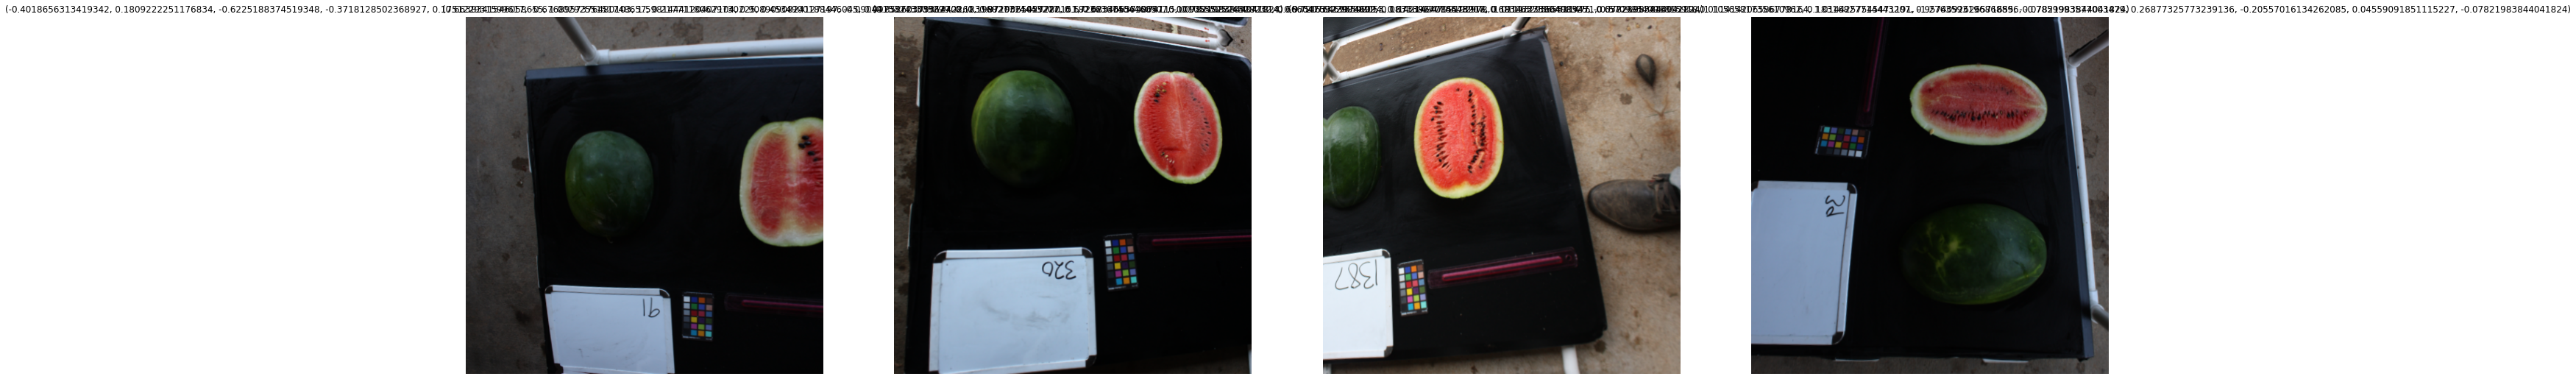

In [26]:
dls.show_batch(nrows=1, ncols=4, figsize=(40,40))

In [27]:
plant.summary(train)

Setting-up type transforms pipelines
215   424      7332      -1.138966  -0.811686   -0.952526      -1.187946   
11      6      6763       1.581714   2.553875    0.713893       1.693482   
8     150      6757      -0.881281  -0.199060   -0.865928      -0.943412   
134   320      6989       0.663834   1.002926    0.217712       0.453490   
111   166      6936      -1.059064  -0.373542   -1.088273      -1.129869   
..    ...       ...            ...        ...         ...            ...   
87    765      6885      -1.548467  -1.645321   -1.069550      -0.955638   
29    117      6786      -0.156165   0.673349   -0.449324      -0.143581   
62    762      6848      -1.253826  -1.048205   -0.908057      -0.445173   
102   758      6917       0.130485   0.665594    0.021112       0.184502   
259   976      7416      -0.642572   0.235205   -0.741883      -0.701934   

     width2_cm  heigth2_cm  prox_angl_macr  distal_angl_macr  \
215  -0.810850   -1.011012       -0.216259          0.650185  

In [28]:
dls.c = n_out_val

In [29]:
dls.c

12

In [30]:
AllData.iloc[:, 2:14].max()

perimeter1_cm                2.866147
width1_cm                    3.348737
heigth1_cm                   3.339906
perimeter2_cm                3.140309
width2_cm                    3.386046
heigth2_cm                   3.387806
prox_angl_macr               2.182559
distal_angl_macr             1.621721
tomat_pericap_area           3.416607
tomat_pericap_area_ratio     2.904337
tomat_pericap_thick          3.009001
tomat_pericap_thick_ratio    7.613398
dtype: float64

In [31]:
AllData.iloc[:, 2:14].min()

perimeter1_cm               -2.721036
width1_cm                   -2.680580
heigth1_cm                  -3.725989
perimeter2_cm               -2.742776
width2_cm                   -2.719545
heigth2_cm                  -2.670074
prox_angl_macr              -2.601485
distal_angl_macr            -5.089271
tomat_pericap_area          -2.756328
tomat_pericap_area_ratio    -4.870431
tomat_pericap_thick         -3.601682
tomat_pericap_thick_ratio   -7.769838
dtype: float64

## Training

In [32]:
model = resnet50

In [33]:
learn = cnn_learner(
               dls, 
               model, 
               metrics = [ MSELossFlat(), mae, rmse, R2Score() ], 
               loss_func = L1LossFlat(),
               y_range=(-4.0,4.0),
)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pt

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [34]:
torch.cuda.empty_cache()
learn.fine_tune(420)

epoch,train_loss,valid_loss,None,mae,_rmse,r2_score,time
0,2.374577,1.887540,4.945269,1.887540,2.223796,-4.898137,01:37


epoch,train_loss,valid_loss,None,mae,_rmse,r2_score,time
0,2.353620,1.867426,4.868208,1.867426,2.206402,-4.806227,01:02
1,2.330519,1.990750,5.397882,1.990750,2.323334,-5.437960,01:01
2,2.294538,1.926179,5.114077,1.926179,2.261432,-5.099469,01:01
3,2.244102,1.718738,4.199591,1.718738,2.049290,-4.008778,01:02
4,2.206634,1.603861,3.682053,1.603861,1.918868,-3.391520,01:01
5,2.159046,1.562305,3.566408,1.562305,1.888494,-3.253592,01:01
6,2.132845,1.461802,3.079654,1.461802,1.754894,-2.673050,01:01
7,2.108300,1.417046,2.940147,1.417046,1.714686,-2.506662,01:01
8,2.083028,1.453657,3.049493,1.453657,1.746280,-2.637077,01:02
9,2.077410,1.457727,3.031264,1.457727,1.741053,-2.615336,01:01


## Inference

In [35]:
learn.export('420epochs.pkl')
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
26,449,6783,0.072556,-1.370027,0.856662,0.102991,-1.275932,0.816260,-1.534589,-1.440730,-0.422715,-0.205570,-0.592682,-0.07822,"[0.07255554337392771, -1.3700274493141102, 0.8566615679702834, 0.10299102967582234, -1.2759317105166572, 0.8162600691003092, -1.5345890285251453, -1.4407303232468465, -0.42271521301340115, -0.20557015459206263, -0.5926819243635918, -0.07821984063462172]"
106,391,6928,-0.274022,0.684981,-0.692733,-0.372832,0.673690,-0.817455,1.326324,1.236275,0.264069,0.960645,0.729455,-0.07822,"[-0.27402160069848835, 0.6849808655538427, -0.6927330901844587, -0.37283174115116413, 0.6736904296668541, -0.8174551561384455, 1.3263237037346114, 1.2362745565754323, 0.2640692607417109, 0.9606451454975246, 0.7294546761398049, -0.07821984063462172]"
52,650,6830,-0.399868,0.107252,-0.470388,-0.191469,0.000252,-0.439558,0.442906,0.766347,-0.161429,0.183168,-0.045591,-0.07822,"[-0.3998680564711818, 0.10725211288341757, -0.4703879353133101, -0.19146888631775166, 0.00025224765690018945, -0.43955769924259885, 0.4429064704952565, 0.7663466782634342, -0.16142921459224713, 0.18316827877113348, -0.045590917258737866, -0.07821984063462172]"
17,436,6769,0.226368,1.444946,-0.414217,0.231371,1.432704,-0.451079,1.598144,1.267955,0.895261,0.960645,1.185364,-0.07822,"[0.22636787820721826, 1.444946204637086, -0.414216527766915, 0.23137147747924958, 1.4327036292802815, -0.45107896317234963, 1.5981443908851822, 1.2679550876975891, 0.8952609688753004, 0.9606451454975246, 1.1853638487271836, -0.07821984063462172]"
160,1632,7191,2.038157,1.813297,1.797533,2.210061,1.827093,1.850870,0.198268,-0.231590,2.332975,0.183168,1.641273,-0.07822,"[2.0381573287759878, 1.8132967516417187, 1.7975326443724067, 2.210060601560636, 1.827092840844121, 1.8508695699919886, 0.19826785205974323, -0.23159005208451566, 2.332975415179589, 0.18316827877113348, 1.6412730213145612, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,781,6884,-1.335726,-1.226565,-0.945504,-1.276589,-1.268490,-1.036359,-0.318191,0.206657,-1.171079,-0.205570,-1.003000,-0.07822,"[-1.3357262236062073, -1.2265646046912526, -0.9455044241432388, -1.2765893379895719, -1.2684904046380943, -1.0363591708037236, -0.3181914535263408, 0.2066572951053248, -1.1710793656108145, -0.20557015459206263, -1.003000179692232, -0.07821984063462172]"
272,578,7432,2.197962,1.146388,2.113497,2.185607,1.142493,2.159639,-1.425861,-0.664557,1.562802,-0.205570,0.775046,-0.07822,"[2.1979623519794083, 1.1463883928543837, 2.1134968118208817, 2.185607182931411, 1.1424927000163234, 2.1596394433093278, -1.4258607536649164, -0.6645573107539968, 1.5628017929921931, -0.20557015459206263, 0.7750455933985427, -0.07821984063462172]"
211,1412,7322,-0.127201,0.498867,-0.358045,-0.100787,0.528585,-0.393473,0.735114,1.014511,0.833254,1.738122,1.367728,-0.07822,"[-0.12720073563034676, 0.498866904962028, -0.35804512022051904, -0.10078745890104544, 0.5285849650348751, -0.39347264352359246, 0.7351137091821208, 1.0145108387203328, 0.8332536533743723, 1.7381220122239167, 1.367727517762135, -0.07821984063462172]"
23,148,6779,-0.918236,-0.226202,-0.858907,-0.031503,0.372318,-0.246000,0.062358,1.104272,-0.799463,-1.760524,-1.094182,-0.07822,"[-0.9182356004872738, -0.22620206651025, -0.8589068375092122, -0.0315027727849097, 0.37231754158505104, -0.24600046522277463, 0.06235750848445785, 1.104272343566444, -0.7994631092638705, -1.7605238880448448, -1.0941820142097078, -0.07821984063462172]"


In [36]:
dl = learn.dls.test_dl(test)

In [37]:
probs, _ = learn.get_preds( dl=dl )

In [38]:
probs.shape

torch.Size([89, 12])

In [39]:
p1 = pd.DataFrame(
           probs
)

In [40]:
p1

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.370210,-0.689899,0.697472,0.360601,-0.684711,0.696916,-0.753398,-0.872501,0.163389,0.244379,0.112171,-0.066451
1,0.086043,0.615348,-0.211135,0.018914,0.636852,-0.277437,0.748819,0.783330,0.358203,0.406407,0.560973,-0.077458
2,0.137483,0.659622,-0.256711,0.066119,0.665795,-0.321405,1.166348,0.880371,0.159942,0.001951,0.250918,-0.064154
3,0.490201,1.139604,-0.022585,0.458626,1.156176,-0.047112,1.147261,0.834207,0.990099,0.759275,1.099114,-0.080678
4,1.673287,1.419322,1.530487,1.764113,1.451034,1.511322,0.194324,0.059926,2.109924,0.750943,1.749711,-0.079687
...,...,...,...,...,...,...,...,...,...,...,...,...
84,-0.807039,-0.650047,-0.652855,-0.819949,-0.696567,-0.741395,0.250162,0.333498,-0.702492,-0.143990,-0.556242,-0.075684
85,1.689527,1.040967,1.753396,1.785857,1.054613,1.751094,-0.588322,-0.550062,1.209713,-0.474805,0.550236,-0.079564
86,0.196557,0.586767,-0.096319,0.097855,0.615428,-0.168462,0.803536,0.675820,0.835056,1.103781,1.137828,-0.078158
87,0.164493,0.499097,-0.002280,0.127722,0.488592,-0.059285,0.227691,0.598068,-0.016529,-0.396907,-0.017950,-0.072072


## De-standardize pandas data frame

In [41]:
p1_np = p1.to_numpy()

In [42]:
p1_np

array([[ 0.3702097 , -0.68989897,  0.6974721 , ...,  0.24437857,
         0.11217117, -0.06645107],
       [ 0.08604336,  0.61534834, -0.21113491, ...,  0.40640688,
         0.56097317, -0.07745838],
       [ 0.13748312,  0.6596222 , -0.25671077, ...,  0.00195074,
         0.2509184 , -0.06415415],
       ...,
       [ 0.19655657,  0.5867667 , -0.0963192 , ...,  1.1037812 ,
         1.1378284 , -0.07815814],
       [ 0.16449308,  0.49909735, -0.00228   , ..., -0.39690685,
        -0.0179503 , -0.07207227],
       [ 0.8212242 , -0.24684381,  1.1662722 , ...,  1.4397216 ,
         1.3427348 , -0.07607961]], dtype=float32)

In [43]:

y_deviations_np = y_deviations.to_numpy()

y_deviations_np

array([1.00122009e+01, 2.57906499e+00, 4.27263639e+00, 9.81457863e+00,
       2.68770029e+00, 4.33980163e+00, 1.47155834e+01, 1.89390764e+01,
       2.33843376e+01, 2.57242381e-02, 2.19341935e-01, 1.30011663e-03])

In [44]:
y_means_np = y_means.to_numpy()

y_means_np

array([ 75.75355932,  18.55338983,  25.25979661,  79.70918644,
        19.53932203,  26.71759322, 124.68237288, 123.68610169,
        79.05491525,   0.18528814,   1.02      ,   0.20010169])

In [45]:
p1_np.shape

(89, 12)

In [46]:

## p1.astype(float)
## p1.iloc[:, 0:12] = (  p1.iloc[:, 0:12] * y_deviations   ) + y_means
## p1 = (p1 * y_deviations) + y_means


In [47]:
p1_np = (  p1_np * y_deviations_np ) + y_means_np

In [48]:
p1_np.shape

(89, 12)

In [49]:
p1_np

array([[79.46017316, 16.77409556, 28.23984127, ...,  0.19157459,
         1.04460384,  0.2000153 ],
       [76.61504271, 20.14041319, 24.35769391, ...,  0.19574264,
         1.14304494,  0.20000099],
       [77.13006794, 20.25459833, 24.16296484, ...,  0.18533832,
         1.07503692,  0.20001829],
       ...,
       [77.72152317, 20.06669934, 24.8482597 , ...,  0.21368207,
         1.26957347,  0.20000008],
       [77.40049713, 19.84059433, 25.25005501, ...,  0.17507801,
         1.01606275,  0.20000799],
       [83.97582114, 17.91676359, 30.2428535 , ...,  0.22232388,
         1.31451805,  0.20000278]])

In [50]:
p1 = pd.DataFrame(
           p1_np, 
           columns=[ list_of_traits ]
)

In [51]:
p1

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,79.460173,16.774096,28.239841,83.248333,17.699024,29.742069,113.595679,107.161732,82.875652,0.191575,1.044604,0.200015
1,76.615043,20.140413,24.357694,79.894822,21.250990,25.513572,135.701680,138.521657,87.431265,0.195743,1.143045,0.200001
2,77.130068,20.254598,24.162965,80.358114,21.328779,25.322761,141.845864,140.359508,82.795056,0.185338,1.075037,0.200018
3,80.661555,21.492502,25.163297,84.210410,22.646776,26.513136,141.564983,139.485204,102.207723,0.204820,1.261082,0.199997
4,92.506849,22.213914,31.799011,97.023212,23.439265,33.276431,127.541957,124.821036,128.394087,0.204606,1.403785,0.199998
...,...,...,...,...,...,...,...,...,...,...,...,...
84,67.673318,16.876877,22.470386,71.661729,17.667159,23.500084,128.363654,130.002246,62.627594,0.181584,0.897993,0.200003
85,92.669443,21.238110,32.751418,97.236618,22.373806,34.316995,116.024869,113.268441,107.343252,0.173074,1.140690,0.199998
86,77.721523,20.066699,24.848260,80.669588,21.193409,25.986500,136.506880,136.485515,98.582143,0.213682,1.269573,0.200000
87,77.400497,19.840594,25.250055,80.962727,20.852510,26.460308,128.032981,135.012962,78.668394,0.175078,1.016063,0.200008


In [52]:
the_list = test["photo_id"].tolist()
the_list

[6783,
 6928,
 6830,
 6769,
 7191,
 7407,
 7011,
 7186,
 6766,
 7192,
 7446,
 7421,
 7225,
 6841,
 7343,
 7714,
 7223,
 7359,
 6857,
 6934,
 7380,
 7311,
 7157,
 6960,
 7189,
 7694,
 6901,
 6891,
 7251,
 6909,
 7169,
 7294,
 6961,
 6752,
 7356,
 6777,
 6847,
 7190,
 7307,
 6868,
 7299,
 7440,
 7419,
 7397,
 6966,
 6811,
 7239,
 7351,
 7232,
 7309,
 6824,
 6778,
 6975,
 7163,
 6828,
 7399,
 6813,
 7331,
 6798,
 7005,
 7179,
 6939,
 7327,
 6900,
 6875,
 7271,
 7355,
 7173,
 7443,
 7429,
 7376,
 6911,
 7390,
 6980,
 6905,
 6981,
 7401,
 6874,
 7220,
 7436,
 6931,
 7437,
 6869,
 6818,
 6884,
 7432,
 7322,
 6779,
 6904]

In [53]:
len(set(the_list))

89

In [54]:
p1['photo_id'] = test["photo_id"].tolist()

In [55]:


cols = ['photo_id', 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
        'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
        'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]

In [56]:
p1[cols]

,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,6783,79.460173,16.774096,28.239841,83.248333,17.699024,29.742069,113.595679,107.161732,82.875652,0.191575,1.044604,0.200015
1,6928,76.615043,20.140413,24.357694,79.894822,21.250990,25.513572,135.701680,138.521657,87.431265,0.195743,1.143045,0.200001
2,6830,77.130068,20.254598,24.162965,80.358114,21.328779,25.322761,141.845864,140.359508,82.795056,0.185338,1.075037,0.200018
3,6769,80.661555,21.492502,25.163297,84.210410,22.646776,26.513136,141.564983,139.485204,102.207723,0.204820,1.261082,0.199997
4,7191,92.506849,22.213914,31.799011,97.023212,23.439265,33.276431,127.541957,124.821036,128.394087,0.204606,1.403785,0.199998
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,6884,67.673318,16.876877,22.470386,71.661729,17.667159,23.500084,128.363654,130.002246,62.627594,0.181584,0.897993,0.200003
85,7432,92.669443,21.238110,32.751418,97.236618,22.373806,34.316995,116.024869,113.268441,107.343252,0.173074,1.140690,0.199998
86,7322,77.721523,20.066699,24.848260,80.669588,21.193409,25.986500,136.506880,136.485515,98.582143,0.213682,1.269573,0.200000
87,6779,77.400497,19.840594,25.250055,80.962727,20.852510,26.460308,128.032981,135.012962,78.668394,0.175078,1.016063,0.200008


In [57]:
p1

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,79.460173,16.774096,28.239841,83.248333,17.699024,29.742069,113.595679,107.161732,82.875652,0.191575,1.044604,0.200015,6783
1,76.615043,20.140413,24.357694,79.894822,21.250990,25.513572,135.701680,138.521657,87.431265,0.195743,1.143045,0.200001,6928
2,77.130068,20.254598,24.162965,80.358114,21.328779,25.322761,141.845864,140.359508,82.795056,0.185338,1.075037,0.200018,6830
3,80.661555,21.492502,25.163297,84.210410,22.646776,26.513136,141.564983,139.485204,102.207723,0.204820,1.261082,0.199997,6769
4,92.506849,22.213914,31.799011,97.023212,23.439265,33.276431,127.541957,124.821036,128.394087,0.204606,1.403785,0.199998,7191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,67.673318,16.876877,22.470386,71.661729,17.667159,23.500084,128.363654,130.002246,62.627594,0.181584,0.897993,0.200003,6884
85,92.669443,21.238110,32.751418,97.236618,22.373806,34.316995,116.024869,113.268441,107.343252,0.173074,1.140690,0.199998,7432
86,77.721523,20.066699,24.848260,80.669588,21.193409,25.986500,136.506880,136.485515,98.582143,0.213682,1.269573,0.200000,7322
87,77.400497,19.840594,25.250055,80.962727,20.852510,26.460308,128.032981,135.012962,78.668394,0.175078,1.016063,0.200008,6779


In [58]:
test

,line,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,combined
26,449,6783,0.072556,-1.370027,0.856662,0.102991,-1.275932,0.816260,-1.534589,-1.440730,-0.422715,-0.205570,-0.592682,-0.07822,"[0.07255554337392771, -1.3700274493141102, 0.8566615679702834, 0.10299102967582234, -1.2759317105166572, 0.8162600691003092, -1.5345890285251453, -1.4407303232468465, -0.42271521301340115, -0.20557015459206263, -0.5926819243635918, -0.07821984063462172]"
106,391,6928,-0.274022,0.684981,-0.692733,-0.372832,0.673690,-0.817455,1.326324,1.236275,0.264069,0.960645,0.729455,-0.07822,"[-0.27402160069848835, 0.6849808655538427, -0.6927330901844587, -0.37283174115116413, 0.6736904296668541, -0.8174551561384455, 1.3263237037346114, 1.2362745565754323, 0.2640692607417109, 0.9606451454975246, 0.7294546761398049, -0.07821984063462172]"
52,650,6830,-0.399868,0.107252,-0.470388,-0.191469,0.000252,-0.439558,0.442906,0.766347,-0.161429,0.183168,-0.045591,-0.07822,"[-0.3998680564711818, 0.10725211288341757, -0.4703879353133101, -0.19146888631775166, 0.00025224765690018945, -0.43955769924259885, 0.4429064704952565, 0.7663466782634342, -0.16142921459224713, 0.18316827877113348, -0.045590917258737866, -0.07821984063462172]"
17,436,6769,0.226368,1.444946,-0.414217,0.231371,1.432704,-0.451079,1.598144,1.267955,0.895261,0.960645,1.185364,-0.07822,"[0.22636787820721826, 1.444946204637086, -0.414216527766915, 0.23137147747924958, 1.4327036292802815, -0.45107896317234963, 1.5981443908851822, 1.2679550876975891, 0.8952609688753004, 0.9606451454975246, 1.1853638487271836, -0.07821984063462172]"
160,1632,7191,2.038157,1.813297,1.797533,2.210061,1.827093,1.850870,0.198268,-0.231590,2.332975,0.183168,1.641273,-0.07822,"[2.0381573287759878, 1.8132967516417187, 1.7975326443724067, 2.210060601560636, 1.827092840844121, 1.8508695699919886, 0.19826785205974323, -0.23159005208451566, 2.332975415179589, 0.18316827877113348, 1.6412730213145612, -0.07821984063462172]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,781,6884,-1.335726,-1.226565,-0.945504,-1.276589,-1.268490,-1.036359,-0.318191,0.206657,-1.171079,-0.205570,-1.003000,-0.07822,"[-1.3357262236062073, -1.2265646046912526, -0.9455044241432388, -1.2765893379895719, -1.2684904046380943, -1.0363591708037236, -0.3181914535263408, 0.2066572951053248, -1.1710793656108145, -0.20557015459206263, -1.003000179692232, -0.07821984063462172]"
272,578,7432,2.197962,1.146388,2.113497,2.185607,1.142493,2.159639,-1.425861,-0.664557,1.562802,-0.205570,0.775046,-0.07822,"[2.1979623519794083, 1.1463883928543837, 2.1134968118208817, 2.185607182931411, 1.1424927000163234, 2.1596394433093278, -1.4258607536649164, -0.6645573107539968, 1.5628017929921931, -0.20557015459206263, 0.7750455933985427, -0.07821984063462172]"
211,1412,7322,-0.127201,0.498867,-0.358045,-0.100787,0.528585,-0.393473,0.735114,1.014511,0.833254,1.738122,1.367728,-0.07822,"[-0.12720073563034676, 0.498866904962028, -0.35804512022051904, -0.10078745890104544, 0.5285849650348751, -0.39347264352359246, 0.7351137091821208, 1.0145108387203328, 0.8332536533743723, 1.7381220122239167, 1.367727517762135, -0.07821984063462172]"
23,148,6779,-0.918236,-0.226202,-0.858907,-0.031503,0.372318,-0.246000,0.062358,1.104272,-0.799463,-1.760524,-1.094182,-0.07822,"[-0.9182356004872738, -0.22620206651025, -0.8589068375092122, -0.0315027727849097, 0.37231754158505104, -0.24600046522277463, 0.06235750848445785, 1.104272343566444, -0.7994631092638705, -1.7605238880448448, -1.0941820142097078, -0.07821984063462172]"


## load test in dataframe to concatenate with p1 pred and compare

In [59]:
test = test.drop(['line', 'photo_id', 'combined'], axis=1)

In [60]:
test

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
26,0.072556,-1.370027,0.856662,0.102991,-1.275932,0.816260,-1.534589,-1.440730,-0.422715,-0.205570,-0.592682,-0.07822
106,-0.274022,0.684981,-0.692733,-0.372832,0.673690,-0.817455,1.326324,1.236275,0.264069,0.960645,0.729455,-0.07822
52,-0.399868,0.107252,-0.470388,-0.191469,0.000252,-0.439558,0.442906,0.766347,-0.161429,0.183168,-0.045591,-0.07822
17,0.226368,1.444946,-0.414217,0.231371,1.432704,-0.451079,1.598144,1.267955,0.895261,0.960645,1.185364,-0.07822
160,2.038157,1.813297,1.797533,2.210061,1.827093,1.850870,0.198268,-0.231590,2.332975,0.183168,1.641273,-0.07822
...,...,...,...,...,...,...,...,...,...,...,...,...
86,-1.335726,-1.226565,-0.945504,-1.276589,-1.268490,-1.036359,-0.318191,0.206657,-1.171079,-0.205570,-1.003000,-0.07822
272,2.197962,1.146388,2.113497,2.185607,1.142493,2.159639,-1.425861,-0.664557,1.562802,-0.205570,0.775046,-0.07822
211,-0.127201,0.498867,-0.358045,-0.100787,0.528585,-0.393473,0.735114,1.014511,0.833254,1.738122,1.367728,-0.07822
23,-0.918236,-0.226202,-0.858907,-0.031503,0.372318,-0.246000,0.062358,1.104272,-0.799463,-1.760524,-1.094182,-0.07822


In [61]:
test_np = test.to_numpy()

In [62]:
test_np = (  test_np * y_deviations_np ) + y_means_np

In [63]:
test_np.shape

(89, 12)

In [64]:
test_df = pd.DataFrame(
           test_np, 
           columns=[ list_of_traits ]
)

In [65]:
test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,76.48,15.02,28.92,80.72,16.11,30.26,102.1,96.4,69.17,0.18,0.89,0.2
1,73.01,20.32,22.30,76.05,21.35,23.17,144.2,147.1,85.23,0.21,1.18,0.2
2,71.75,18.83,23.25,77.83,19.54,24.81,131.2,138.2,75.28,0.19,1.01,0.2
3,78.02,22.28,23.49,81.98,23.39,24.76,148.2,147.7,99.99,0.21,1.28,0.2
4,96.16,23.23,32.94,101.40,24.45,34.75,127.6,119.3,133.61,0.19,1.38,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...
84,62.38,15.39,21.22,67.18,16.13,22.22,120.0,127.6,51.67,0.18,0.80,0.2
85,97.76,21.51,34.29,101.16,22.61,36.09,103.7,111.1,115.60,0.18,1.19,0.2
86,74.48,19.84,23.73,78.72,20.96,25.01,135.5,142.9,98.54,0.23,1.32,0.2
87,66.56,17.97,21.59,79.40,20.54,25.65,125.6,144.6,60.36,0.14,0.78,0.2


In [66]:
test_df['photo_id'] = the_list

In [67]:
cols = ['photo_id', 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
        'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
        'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio' ]



In [68]:
test_df[cols]

,photo_id,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio
0,6783,76.48,15.02,28.92,80.72,16.11,30.26,102.1,96.4,69.17,0.18,0.89,0.2
1,6928,73.01,20.32,22.30,76.05,21.35,23.17,144.2,147.1,85.23,0.21,1.18,0.2
2,6830,71.75,18.83,23.25,77.83,19.54,24.81,131.2,138.2,75.28,0.19,1.01,0.2
3,6769,78.02,22.28,23.49,81.98,23.39,24.76,148.2,147.7,99.99,0.21,1.28,0.2
4,7191,96.16,23.23,32.94,101.40,24.45,34.75,127.6,119.3,133.61,0.19,1.38,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,6884,62.38,15.39,21.22,67.18,16.13,22.22,120.0,127.6,51.67,0.18,0.80,0.2
85,7432,97.76,21.51,34.29,101.16,22.61,36.09,103.7,111.1,115.60,0.18,1.19,0.2
86,7322,74.48,19.84,23.73,78.72,20.96,25.01,135.5,142.9,98.54,0.23,1.32,0.2
87,6779,66.56,17.97,21.59,79.40,20.54,25.65,125.6,144.6,60.36,0.14,0.78,0.2


In [69]:
test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,76.48,15.02,28.92,80.72,16.11,30.26,102.1,96.4,69.17,0.18,0.89,0.2,6783
1,73.01,20.32,22.30,76.05,21.35,23.17,144.2,147.1,85.23,0.21,1.18,0.2,6928
2,71.75,18.83,23.25,77.83,19.54,24.81,131.2,138.2,75.28,0.19,1.01,0.2,6830
3,78.02,22.28,23.49,81.98,23.39,24.76,148.2,147.7,99.99,0.21,1.28,0.2,6769
4,96.16,23.23,32.94,101.40,24.45,34.75,127.6,119.3,133.61,0.19,1.38,0.2,7191
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,62.38,15.39,21.22,67.18,16.13,22.22,120.0,127.6,51.67,0.18,0.80,0.2,6884
85,97.76,21.51,34.29,101.16,22.61,36.09,103.7,111.1,115.60,0.18,1.19,0.2,7432
86,74.48,19.84,23.73,78.72,20.96,25.01,135.5,142.9,98.54,0.23,1.32,0.2,7322
87,66.56,17.97,21.59,79.40,20.54,25.65,125.6,144.6,60.36,0.14,0.78,0.2,6779


In [70]:
new_p1_np   = p1.to_numpy() 
new_test_np = test_df.to_numpy()

In [71]:
combined_np = np.concatenate((new_p1_np, new_test_np), axis=0)

In [72]:
combined_np

array([[7.94601732e+01, 1.67740956e+01, 2.82398413e+01, ...,
        1.04460384e+00, 2.00015301e-01, 6.78300000e+03],
       [7.66150427e+01, 2.01404132e+01, 2.43576939e+01, ...,
        1.14304494e+00, 2.00000990e-01, 6.92800000e+03],
       [7.71300679e+01, 2.02545983e+01, 2.41629648e+01, ...,
        1.07503692e+00, 2.00018287e-01, 6.83000000e+03],
       ...,
       [7.44800000e+01, 1.98400000e+01, 2.37300000e+01, ...,
        1.32000000e+00, 2.00000000e-01, 7.32200000e+03],
       [6.65600000e+01, 1.79700000e+01, 2.15900000e+01, ...,
        7.80000000e-01, 2.00000000e-01, 6.77900000e+03],
       [7.94000000e+01, 1.55600000e+01, 2.96000000e+01, ...,
        1.20000000e+00, 2.00000000e-01, 6.90400000e+03]])

In [73]:
combined_np.shape

(178, 13)

In [74]:

list_of_traits_r = [ 'perimeter1_cm','width1_cm','heigth1_cm','perimeter2_cm','width2_cm', 
                  'heigth2_cm','prox_angl_macr','distal_angl_macr','tomat_pericap_area', 
                  'tomat_pericap_area_ratio', 'tomat_pericap_thick','tomat_pericap_thick_ratio', 'photo_id' ]

combined_pred_test_df = pd.DataFrame(
                                combined_np, 
                                columns=[ list_of_traits_r ]
)

In [75]:
combined_pred_test_df

,perimeter1_cm,width1_cm,heigth1_cm,perimeter2_cm,width2_cm,heigth2_cm,prox_angl_macr,distal_angl_macr,tomat_pericap_area,tomat_pericap_area_ratio,tomat_pericap_thick,tomat_pericap_thick_ratio,photo_id
0,79.460173,16.774096,28.239841,83.248333,17.699024,29.742069,113.595679,107.161732,82.875652,0.191575,1.044604,0.200015,6783.0
1,76.615043,20.140413,24.357694,79.894822,21.250990,25.513572,135.701680,138.521657,87.431265,0.195743,1.143045,0.200001,6928.0
2,77.130068,20.254598,24.162965,80.358114,21.328779,25.322761,141.845864,140.359508,82.795056,0.185338,1.075037,0.200018,6830.0
3,80.661555,21.492502,25.163297,84.210410,22.646776,26.513136,141.564983,139.485204,102.207723,0.204820,1.261082,0.199997,6769.0
4,92.506849,22.213914,31.799011,97.023212,23.439265,33.276431,127.541957,124.821036,128.394087,0.204606,1.403785,0.199998,7191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,62.380000,15.390000,21.220000,67.180000,16.130000,22.220000,120.000000,127.600000,51.670000,0.180000,0.800000,0.200000,6884.0
174,97.760000,21.510000,34.290000,101.160000,22.610000,36.090000,103.700000,111.100000,115.600000,0.180000,1.190000,0.200000,7432.0
175,74.480000,19.840000,23.730000,78.720000,20.960000,25.010000,135.500000,142.900000,98.540000,0.230000,1.320000,0.200000,7322.0
176,66.560000,17.970000,21.590000,79.400000,20.540000,25.650000,125.600000,144.600000,60.360000,0.140000,0.780000,0.200000,6779.0


In [76]:
combined_pred_test_df.to_csv('preds_vs_real.watermelon.csv') 

In [76]:
print('test')
print('please')
print("don't let it disconnect me from my precious runtime")
print('doing good at 156')


had a captcha scare at 200

hope it doesn't happen again

In [ ]:
print('"just keep swimming" - dory')

In [ ]:
print('certainly doing good at this point')

In [ ]:
print(f'I am beginning to become sleepy')